# SBvar Tutorial 

This is an example of using sbvar to perform varying parameter analysis on reaction models. 

# Import Packages
We will first import main packages for the analysis:
- sbvar: varying parameter analysis
- tellurium: loading antimony model

Other packages for showing non-sbvar components
- matplotlib.pyplot: additional plots outside of sbvar
- numpy: array manipulation

In [1]:
import sbvar as sb
import tellurium as te

import matplotlib.pyplot as plt
import numpy as np

We will define a model that is a bistable system, where simulations with different starting concentrations for S1 will result in different steady states.

In [2]:
rr = te.loada ('''
J0: $Xo -> S1; 1 + Xo*(32+(S1/0.75)^3.2)/(1 +(S1/4.3)^3.2);
J1: S1 -> $X1; k1*S1;

Xo = 0.09; X1 = 0.0;
S1 = 0.5; k1 = 3.2;
''')

Outside of using sbvar, we can use for loops to manually change the initial condition and simulate each condition. The timeseries are concatentated and then plotted.

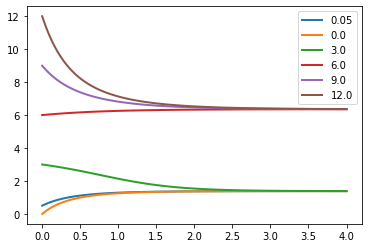

In [3]:
initValue = 0.05
m = rr.simulate (0, 4, 100, selections=["time", "S1"])
values = np.linspace(0, 12, 5)
for i in values:
    rr.reset()
    rr['S1'] = i 
    y = rr.simulate(0, 4, 100, ['S1'])
    m = np.concatenate([m, y], axis=1)
plt.figure()
ax = te.plotArray(m, labels=np.insert(values, 0, 0.05))


# One-Way Design of Experiment
We will now use sbvar to do similar analysis with fewer steps and further extend the analysis.
We will first define a one-way experiment, where we change one parameter over a range of levels.

sbvar has a class `OneWayExperiment` class that would take the model and your specified levels and automatically perform simulation and steady state calculations for all species concentrations and derivatives and reaction rates. You must specify the parameter using the `param`. To determine the range of values, you can explicitly specify discrete `levels` as a list, or provide the bounds of the range as a tuple `(start, end)` with `num` indiciating the number of evenly spaced samples.

For any `Experiment` derived class, you can specify the `start` and `end` time of simuations, where each has `points` number of evenly spaced timepoints.

For calculating steady states, you may want to specify `conserved_moiety` as True, if the model contains moiety conserved cycles.

Here we specify one-way experiment using the loaded model `rr`. The experiment will vary initial concentrations of 'S1' from 0 to 12 (with 40 evenly spaced points). The simulations will span from t=0 until t=4, with 100 evenly spaced time points.
We will not use conserved moiety analysis.

In [4]:
exp = sb.experiment.OneWayExperiment(rr, param='S1', 
    bounds=(0,12), num=40, start=0, end=4, points=100, 
    conserved_moiety=True)

When we created the experiment object, the list of conditions are generated and stored in the `obs` attribute as a dataframe where rows correspond to one condition. Downstream analysis can add columns to annotate each condition.  Here we will display the first 10 conditons.

In [5]:
exp.obs.head(10)

,S1
0,0.000000
1,0.307692
2,0.615385
3,0.923077
4,1.230769
5,1.538462
6,1.846154
7,2.153846
8,2.461538
9,2.769231


By default, the selections (i.e. variables) to keep track of in the simulation and steady state calculation are automatically determined. The default simulation selections are all floating species' concentrations and fluxes, and reaction rates. The default steady state selections are the same as simulation except that fluxes are excluded (assumed to be 0).


In [6]:
print("Simulation Selections:", exp.selections)
print("Steady State Selections:",exp.steady_state_selections)
print("Floating Species Concentratons:",exp.species_ids)
print("Floating Species Fluxes:",exp.flux_ids)
print("Reaction Rates:", exp.reaction_ids)

Simulation Selections: ['time', 'S1', "S1'", 'J0', 'J1']
Steady State Selections: ['S1', 'J0', 'J1']
Floating Species Concentratons: ['S1']
Floating Species Fluxes: ["S1'"]
Reaction Rates: ['J0', 'J1']


Now, run simulations and calculate steady states for all condition.
If steady state calculationg fails, you can choose set `approximate=True` to approximate the steady state solution.  

In [7]:
exp.simulate()
exp.calc_steady_state(approximate=False)

We can visualize how the timeseries changes as we vary S1 initial concentrations. 
Using `plot_timecourse_mesh`, we can visualize all timeseries as a 2D filled contour plot or a 3D surface.

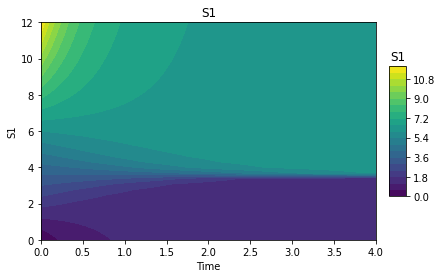

In [8]:
fig, ax, cax = exp.plot_timecourse_mesh('S1', levels=20)


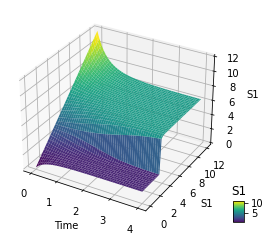

In [9]:
fig, ax, cax = exp.plot_timecourse_mesh('S1', kind='surface', projection='3d')


See that there are one steady state value for each variable for each condition stored in the `steady_states` attribute. We can plot the relationship of S1 steady state and S1 initial condition as a line plot. We see that at steady state, S1 production and degradation are active. Comparing it to line plot of the last time step, we see that the calculated steady state based on matrix calculations are different.

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:xlabel='S1', ylabel='J1'>)

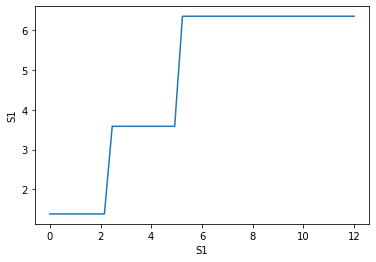

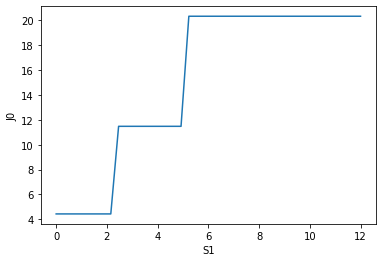

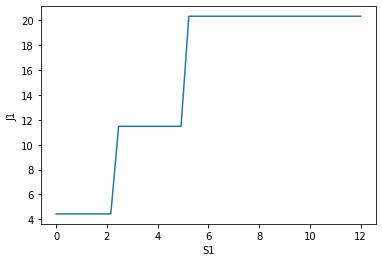

In [10]:
exp.plot_line("S1", steady_state=True)
exp.plot_line("J0", steady_state=True)
exp.plot_line("J1", steady_state=True)


(<Figure size 432x288 with 1 Axes>, <AxesSubplot:xlabel='S1', ylabel='S1'>)

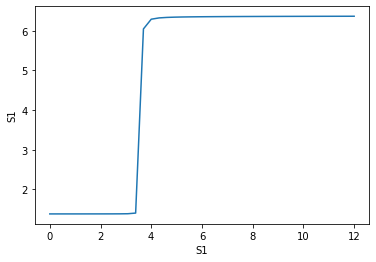

In [11]:
exp.plot_line("S1", steady_state=False, step=-1) # Last step

Lineplot of S1 values at the first time point is a diagonal line as expected.

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:xlabel='S1', ylabel='S1'>)

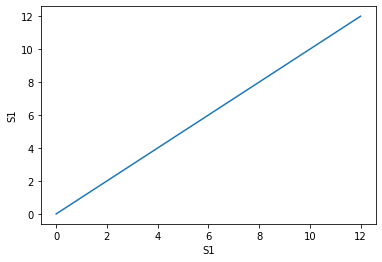

In [12]:
exp.plot_line("S1", steady_state=False, step=0) # Last step

# Timeseries clustering
Sbvar has additional downstream analysis that can be performed to annotate each condition. For example, we can cluster the conditions based on the simulated S1 time course using K-means clustering. The clustering labels each condition with a cluster index, which is added to the `obs` dataframe. 

In [13]:
sb.timeseries.cluster_timeseries(exp, 'S1', 'kmeans', n_clusters=4)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [14]:
exp.obs.head(10)

,S1,kmeans_S1
0,0.000000,1
1,0.307692,1
2,0.615385,1
3,0.923077,1
4,1.230769,1
5,1.538462,1
6,1.846154,1
7,2.153846,1
8,2.461538,1
9,2.769231,1


We can visualize the clustering results different ways:
- lineplot of cluster labels 
- 2D contour plot of time series along with the cluster labels.

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'S1'}, xlabel='Time', ylabel='S1'>)

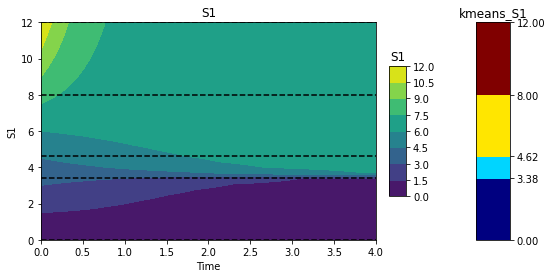

In [15]:
sb.timeseries.plot_timecourse_clusters(exp, 'S1', 'kmeans', dashline=True)

# Two-Way Design of Experiment
sbvar has a different class for varying two parameters simultaneously. Similarly, we define `param`, `bounds`, `num`, `levels` (add 1 or 2 to end of variable name) for specifying the parameters. It takes in the same arugments for specifying simulations timepoints. 

Here we specify two-way experiment using the loaded model `rr`. The experiment will vary initial concentrations of S1 from 0 to 12 (with 40 evenly spaced points) and try three values of boundary species Xo = [0.089, 0.9, 0.91]. The simulations will span from t=0 until t=4, with 100 evenly spaced time points.
We will not use conserved moiety analysis.

In [16]:
rr.reset()
exp2d = sb.experiment.TwoWayExperiment(rr, param1='S1', param2='Xo', 
    bounds1=(0,12), num1=20, 
    levels2=[0.089, 0.09, 0.091],
    start=0, end=4, points=50)

In [17]:
exp2d.simulate()
exp2d.calc_steady_state()


In [18]:
exp2d.obs.head(10)

,S1,Xo
0,0.000000,0.089
1,0.631579,0.089
2,1.263158,0.089
3,1.894737,0.089
4,2.526316,0.089
5,3.157895,0.089
6,3.789474,0.089
7,4.421053,0.089
8,5.052632,0.089
9,5.684211,0.089


Since we are varying two parameters, the response (steady state, or particular timepoint) can be plotted as a function of the two axes. 

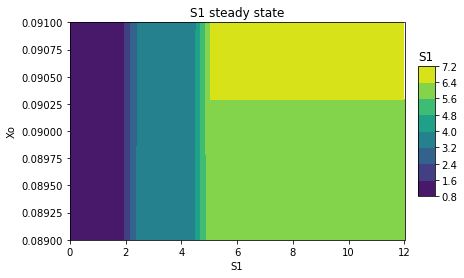

In [19]:
fig, ax, cax = exp2d.plot_mesh("S1", steady_state=True)
ax.set_title('S1 steady state');

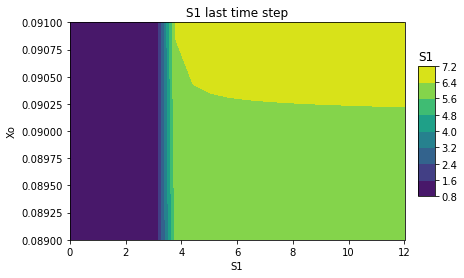

In [20]:
fig, ax, cax = exp2d.plot_mesh("S1", steady_state=False, step=-1)
ax.set_title('S1 last time step');


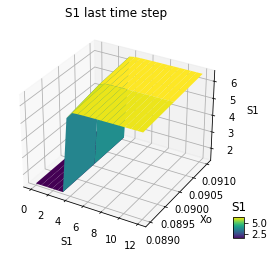

In [21]:
fig, ax, cax = exp2d.plot_mesh("S1", steady_state=False, step=-1, kind='surface', projection='3d')
ax.set_title('S1 last time step');
